In [3]:
import os
import torch
import torch.nn.functional as F
from dataclasses import dataclass, field
from pathlib import Path
from typing import Union, Optional
from prismatic.models import get_llm_backbone_and_tokenizer, get_vision_backbone_and_transform, get_vlm
from prismatic.overwatch import initialize_overwatch
from prismatic.preprocessing import get_dataset_and_collator
from prismatic.conf import DatasetConfig, DatasetRegistry, ModelConfig, ModelRegistry
from prismatic.util.batching_utils import SplitModalitySampler
from torch.utils.data import DataLoader, Dataset, DistributedSampler
import draccus
from accelerate.utils import set_seed

from vlm_eval.models import load_vlm
from vlm_eval.overwatch import initialize_overwatch
from vlm_eval.tasks import get_task_runner

# Assuming 'output' contains the logits, and they are already squeezed.
# Convert logits to softmax probabilities

def plot_top_probs(probs, top_n_probs=15, first_n_tokens=100, RUN_DIR=None):
    import matplotlib.pyplot as plt
    import seaborn as sns
    # Step 1: Extract probabilities for the first 100 tokens
    probs_first_100_tokens = probs[:-first_n_tokens, :]  # Shape: [100, 50304]

    # Step 2: For each token, select the top 100 probabilities from the 50304 vocabulary options
    top_probs, top_indices = torch.topk(probs_first_100_tokens, k=top_n_probs, dim=-1)

    # Step 3: Convert tensors to numpy for plotting
    top_probs_np = top_probs.to(torch.float16).detach().cpu().numpy()

    # Step 4: Plotting the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(top_probs_np, cbar=True)

    # Customize the plot with labels and title
    # Increase font size of the labels and titles, axes 
    plt.title(f'Heatmap of Top {top_n_probs} Vocabulary Probabilities for First {first_n_tokens} Tokens')
    plt.xlabel(f'Top {top_n_probs} Vocabulary Indices' , fontsize=18)
    plt.ylabel(f'First {first_n_tokens} Tokens', fontsize=18)
    
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    plt.show()
    model_name = RUN_DIR.split('/')[-1]
    plt.savefig(f'{model_name}.png', dpi=300)
    return plt

os.chdir('/localdisk/ssrivas9/prismatic-vlms')

def inference_and_plot(RUN_DIR, new_input_text):
    vlm = load_vlm('prismatic', 'prism-clip+7b', RUN_DIR, hf_token=None)
    tokenizer, image_transform = vlm.model.llm_backbone.tokenizer, vlm.model.vision_backbone.image_transform
    dataset_cfg: DatasetConfig = DatasetConfig.get_choice_class('llava-v15')

    train_dataset, collator = get_dataset_and_collator(
            'finetune',
            dataset_cfg,
            image_transform,
            tokenizer,
            prompt_builder_fn=vlm.model.llm_backbone.prompt_builder_fn,
            default_image_resolution=vlm.model.vision_backbone.default_image_resolution,
            padding_side=tokenizer.padding_side,
        )
    modality_lengths = train_dataset.get_modality_lengths()
    sampler = SplitModalitySampler(
            train_dataset,
            modality_lengths,
            global_batch_size=1,
            num_replicas=1,
            rank=0,
            seed=123,
            drop_last=False,
        )

    dataloader = DataLoader(
            train_dataset,
            batch_size=1,
            sampler=sampler,
            collate_fn=collator,
            num_workers=12,
            worker_init_fn=None,
        )
    data_iter = iter(dataloader)
    batch = next(data_iter)
    #batch = next(data_iter)
    new_input_ids = tokenizer(new_input_text, truncation=True, return_tensors="pt").input_ids.to(vlm.model.device)

    with torch.autocast("cuda", dtype=torch.bfloat16):
        batch = {k: v.to("cuda") if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
        output = vlm.model(
                    input_ids= batch["input_ids"],
                        attention_mask=batch["attention_mask"],
                        pixel_values=batch["pixel_values"],
                        labels=batch["labels"],
                        multimodal_indices=batch["multimodal_indices"],
                    )

    input_ids = batch["input_ids"]
    decoded_input = tokenizer.decode(input_ids.flatten()).strip()
    # Ignore special tokens for output
    decoded_output = tokenizer.decode(output.logits.argmax(dim=-1).flatten()[new_input_ids.shape[1] :], skip_special_tokens=True).strip()
    #print("Decoded Input:", decoded_input)
    print("Decoded Output:", decoded_output)
    probs = F.softmax(output.logits.squeeze(0), dim=-1)
    plt = plot_top_probs(probs, RUN_DIR = RUN_DIR)
    # Get the name of the model by splitting the RUN_DIR using '/' and selecting -1 index
    # Save the plt with 300 dpi using the model name
    


loading prismatic <vlm_eval.models.prismatic.PrismaticVLM object at 0x7f9b6e875e40>


09/13 [12:36:32] INFO     | >> [*] Loading from local path                                               ]8;id=62417;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py\load.py]8;;\:]8;id=31011;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py#55\55]8;;\
                          `/localdisk/ssrivas9/prismatic-vlms/runs/stage-final-llava-v15-pythia+2p8b-sof           
                          t`                                                                                       

                 INFO     | >> [*]                                                                       ]8;id=862741;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py\load.py]8;;\:]8;id=248589;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py#70\70]8;;\
                                                                                                                   
                          🚀 (LATEST) Loading Prismatic VLM for Inference 🚀 🚀                                    
                                                                                                                   
                                                                                                                   

                 INFO     | >> [*] Found Config =>> Loading & Freezing stage0-pythia+2p8b with:          ]8;id=769860;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py\load.py]8;;\:]8;id=294770;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py#78\78]8;;\
                                       Vision Backbone =>> clip-vit-l-336px                                        
                                       LLM Backbone    =>> pythia-2p8b                                             
                                       Arch Specifier  =>> gelu-mlp                                                
                                       Mitigation Strategy      =>> None             LoRA      =>> rank:           
                          16, alpha: 8, lora_target_modules: all-linear             Load in 8bit     =>>           
                          False             Checkpoint Path =>>                                                    
                          `/localdisk/ssrivas9/prismatic-vlms/runs/stage-final-llava-v15-pythia+2p8b-sof           
                          t/checkpoints/latest-checkpoint.pt`                                                      

                 INFO     | >> [*] Loading Vision Backbone clip-vit-l-336px                              ]8;id=390102;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py\load.py]8;;\:]8;id=481693;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py#89\89]8;;\

09/13 [12:36:36] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=237534;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=390734;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (('timm/vit_large_patch14_clip_336.openai',                                              
                          'open_clip_pytorch_model.bin'))                                                          

                 INFO     | >> [*] Loading Pretrained LLM pythia-2p8b via HF Transformers               ]8;id=777363;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py\load.py]8;;\:]8;id=760251;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py#103\103]8;;\

                 INFO     | >>     |=> Building empty pythia LLM from                               ]8;id=196139;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=79393;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/backbones/llm/base_llm.py#213\213]8;;\
                          `EleutherAI/pythia-2.8b-deduped`                                                         

09/13 [12:37:02] INFO     | >>     |=> Loading pythia (Fast) Tokenizer via the AutoTokenizer API    ]8;id=949724;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=276569;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/backbones/llm/base_llm.py#245\245]8;;\

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


                 INFO     | >> [*] Loading VLM stage0-pythia+2p8b from Checkpoint; Freezing Weights 🥶  ]8;id=798489;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py\load.py]8;;\:]8;id=11756;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py#113\113]8;;\

                 INFO     | >> [*] Dimensions of Projector:                                         ]8;id=496462;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/vlms/prismatic.py\prismatic.py]8;;\:]8;id=387740;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/vlms/prismatic.py#70\70]8;;\
                           vision_dim: 1024, llm_dim: 2560                                                         

                 INFO     | >> [*] Total Parameters: 9175040                                        ]8;id=584625;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/vlms/prismatic.py\prismatic.py]8;;\:]8;id=289538;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/vlms/prismatic.py#71\71]8;;\

09/13 [12:37:05] INFO     | >>     |=> Loading `projector` and `llm_backbone` from checkpoint      ]8;id=876203;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/vlms/prismatic.py\prismatic.py]8;;\:]8;id=332246;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/vlms/prismatic.py#114\114]8;;\

loaded prismatic prism-clip+7b
Decoded Output: of






 of
 party party room with
 with

 with house room party house
 party party with room with house
 of


 with withroomroomroom with house house with with with with wall wall with with with with


 with

 with with with with house door wood wood wood wood withe


room
 with
 and and ra with with with with wood wood

 wood window with withroom with girl girl man man man boxes box wooden wood of
 wall wooden

 with-, house with-- hair hair with with with with wood in in in in in steps steps women women. women. with boxes bottle bottleers television

 of in of in of steps in in women women women man wood bottle bottle wall with of women and shirts and and are wood in in in sit sit man man music with with
 and man of and in with wood sit are and and sit on computer, television with background wall party man in men in in in in with in and and and and in men man man is with game game a on playing and men with playing in shirt and and and 

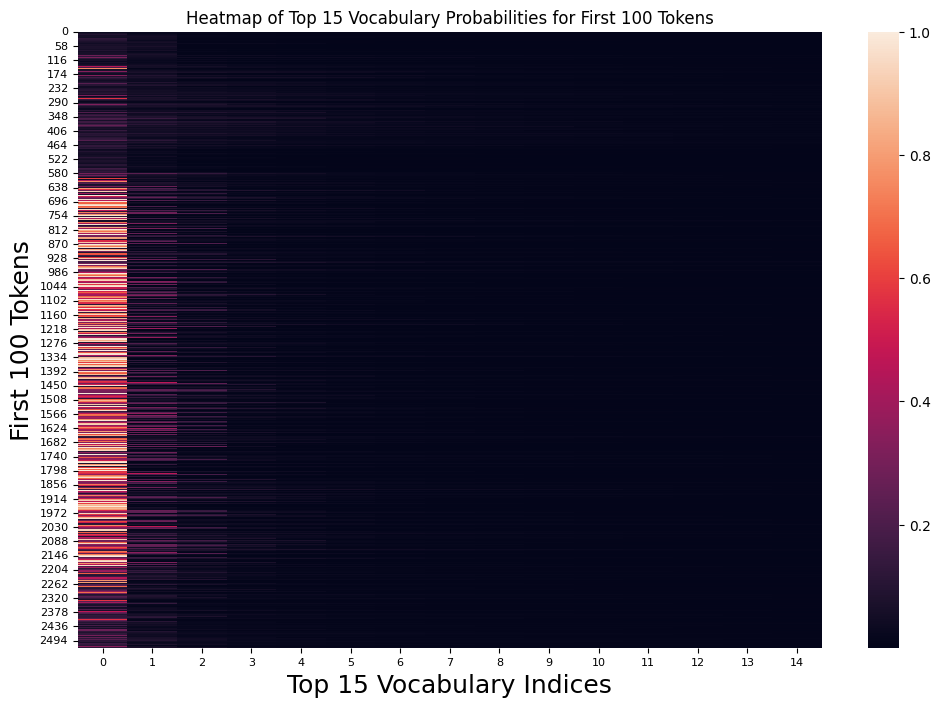

<Figure size 640x480 with 0 Axes>

In [4]:
RUN_DIR = '/localdisk/ssrivas9/prismatic-vlms/runs/stage-final-llava-v15-pythia+2p8b-soft'
new_input_text = "A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: Is this person alone? Answer the question using a single word or phrase. ASSISTANT:"

inference_and_plot(RUN_DIR, new_input_text)

loading prismatic <vlm_eval.models.prismatic.PrismaticVLM object at 0x7f9b6e82c520>


09/13 [12:37:35] INFO     | >> [*] Loading from local path                                               ]8;id=402000;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py\load.py]8;;\:]8;id=706393;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py#55\55]8;;\
                          `/localdisk/ssrivas9/prismatic-vlms/runs/stage-final-llava-v15-pythia+2p8b`              

                 INFO     | >> [*]                                                                       ]8;id=686635;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py\load.py]8;;\:]8;id=313983;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py#70\70]8;;\
                                                                                                                   
                          🚀 (LATEST) Loading Prismatic VLM for Inference 🚀 🚀                                    
                                                                                                                   
                                                                                                                   

                 INFO     | >> [*] Found Config =>> Loading & Freezing stage0-pythia+2p8b with:          ]8;id=995786;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py\load.py]8;;\:]8;id=997096;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py#78\78]8;;\
                                       Vision Backbone =>> clip-vit-l-336px                                        
                                       LLM Backbone    =>> pythia-2p8b                                             
                                       Arch Specifier  =>> gelu-mlp                                                
                                       Mitigation Strategy      =>> None             LoRA      =>> rank:           
                          16, alpha: 8, lora_target_modules: all-linear             Load in 8bit     =>>           
                          False             Checkpoint Path =>>                                                    
                          `/localdisk/ssrivas9/prismatic-vlms/runs/stage-final-llava-v15-pythia+2p8b/che           
                          ckpoints/latest-checkpoint.pt`                                                           

                 INFO     | >> [*] Loading Vision Backbone clip-vit-l-336px                              ]8;id=731557;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py\load.py]8;;\:]8;id=997356;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py#89\89]8;;\

09/13 [12:37:38] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=141976;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=423070;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (('timm/vit_large_patch14_clip_336.openai',                                              
                          'open_clip_pytorch_model.bin'))                                                          

09/13 [12:37:39] INFO     | >> [*] Loading Pretrained LLM pythia-2p8b via HF Transformers               ]8;id=67767;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py\load.py]8;;\:]8;id=116791;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py#103\103]8;;\

                 INFO     | >>     |=> Building empty pythia LLM from                               ]8;id=707854;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=443049;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/backbones/llm/base_llm.py#213\213]8;;\
                          `EleutherAI/pythia-2.8b-deduped`                                                         

09/13 [12:38:05] INFO     | >>     |=> Loading pythia (Fast) Tokenizer via the AutoTokenizer API    ]8;id=823688;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=954399;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/backbones/llm/base_llm.py#245\245]8;;\

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


                 INFO     | >> [*] Loading VLM stage0-pythia+2p8b from Checkpoint; Freezing Weights 🥶  ]8;id=412644;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py\load.py]8;;\:]8;id=895913;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py#113\113]8;;\

                 INFO     | >> [*] Dimensions of Projector:                                         ]8;id=434278;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/vlms/prismatic.py\prismatic.py]8;;\:]8;id=137300;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/vlms/prismatic.py#70\70]8;;\
                           vision_dim: 1024, llm_dim: 2560                                                         

                 INFO     | >> [*] Total Parameters: 9175040                                        ]8;id=121557;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/vlms/prismatic.py\prismatic.py]8;;\:]8;id=408107;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/vlms/prismatic.py#71\71]8;;\

09/13 [12:38:07] INFO     | >>     |=> Loading `projector` and `llm_backbone` from checkpoint      ]8;id=581736;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/vlms/prismatic.py\prismatic.py]8;;\:]8;id=426063;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/vlms/prismatic.py#114\114]8;;\

loaded prismatic prism-clip+7b
Decoded Output: YesYesYesYesYesYesYesYesYesYesNoNo athethethetheA thethetheThethethethethethethethe roomthe with club club withthe withthethe party party roomthe athethethe with with room with with with house room with window with door door window withthethethe withthethethethe doorthethe with hair hair hair hair door door woodenthethe in are hair manthethethethe are are are in inways women wearing man. with...YesYes door are in are in areways in man man in in..thethe are in and shirt with are in in in are in..AYes are shirts in in in and and are.the a man are man in in are in. wearing and and and and in. on. on with in in. in in in are shirt and and and computer computer.. w w.. in are. in in are are are. shirts are. in music.. on man with with in on men a in with and shirts are in exercising shirt computer. man man man. a man a on man shirt in are in in are music.. a man mat a watch man in with and in music musicTTTTT man a athethethethethethe a manthet

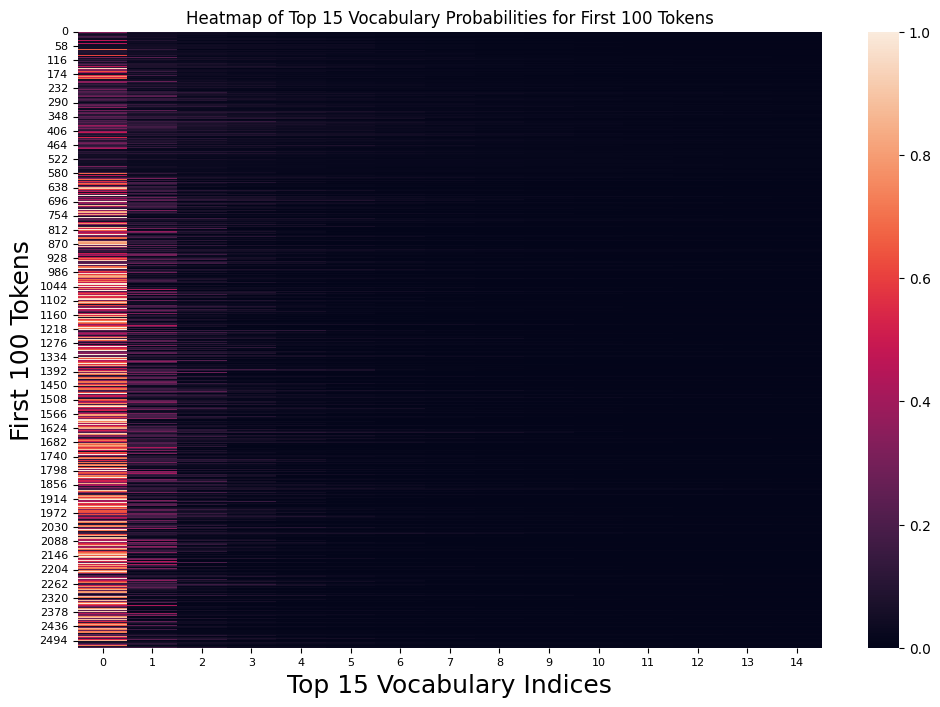

<Figure size 640x480 with 0 Axes>

In [5]:
RUN_DIR = '/localdisk/ssrivas9/prismatic-vlms/runs/stage-final-llava-v15-pythia+2p8b'
new_input_text = "A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: Is this person alone? Answer the question using a single word or phrase. ASSISTANT:"

inference_and_plot(RUN_DIR, new_input_text)

loading prismatic <vlm_eval.models.prismatic.PrismaticVLM object at 0x7f9b792abeb0>


09/13 [12:38:38] INFO     | >> [*] Loading from local path                                               ]8;id=176052;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py\load.py]8;;\:]8;id=911971;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py#55\55]8;;\
                          `/localdisk/ssrivas9/prismatic-vlms/runs/reproduction-align-pythia+2p8b`                 

                 INFO     | >> [*]                                                                       ]8;id=646665;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py\load.py]8;;\:]8;id=351729;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py#70\70]8;;\
                                                                                                                   
                          🚀 (LATEST) Loading Prismatic VLM for Inference 🚀 🚀                                    
                                                                                                                   
                                                                                                                   

                 INFO     | >> [*] Found Config =>> Loading & Freezing stage0-pythia+2p8b with:          ]8;id=293475;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py\load.py]8;;\:]8;id=290937;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py#78\78]8;;\
                                       Vision Backbone =>> clip-vit-l-336px                                        
                                       LLM Backbone    =>> pythia-2p8b                                             
                                       Arch Specifier  =>> gelu-mlp                                                
                                       Mitigation Strategy      =>> None             LoRA      =>> rank:           
                          16, alpha: 8, lora_target_modules: all-linear             Load in 8bit     =>>           
                          False             Checkpoint Path =>>                                                    
                          `/localdisk/ssrivas9/prismatic-vlms/runs/reproduction-align-pythia+2p8b/checkp           
                          oints/latest-checkpoint.pt`                                                              

                 INFO     | >> [*] Loading Vision Backbone clip-vit-l-336px                              ]8;id=315534;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py\load.py]8;;\:]8;id=375162;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py#89\89]8;;\

09/13 [12:38:42] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=451392;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=982821;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (('timm/vit_large_patch14_clip_336.openai',                                              
                          'open_clip_pytorch_model.bin'))                                                          

                 INFO     | >> [*] Loading Pretrained LLM pythia-2p8b via HF Transformers               ]8;id=927414;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py\load.py]8;;\:]8;id=836208;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py#103\103]8;;\

09/13 [12:38:43] INFO     | >>     |=> Loading pythia (Fast) Tokenizer via the AutoTokenizer API    ]8;id=679029;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=60089;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/backbones/llm/base_llm.py#245\245]8;;\

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


                 INFO     | >> [*] Loading VLM stage0-pythia+2p8b from Checkpoint; Freezing Weights 🥶  ]8;id=578129;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py\load.py]8;;\:]8;id=770038;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/load.py#113\113]8;;\

                 INFO     | >> [*] Dimensions of Projector:                                         ]8;id=615364;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/vlms/prismatic.py\prismatic.py]8;;\:]8;id=232068;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/vlms/prismatic.py#70\70]8;;\
                           vision_dim: 1024, llm_dim: 2560                                                         

                 INFO     | >> [*] Total Parameters: 9175040                                        ]8;id=126711;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/vlms/prismatic.py\prismatic.py]8;;\:]8;id=452464;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/vlms/prismatic.py#71\71]8;;\

                 ERROR    | >>     |=> Loading only `projector` from checkpoint                    ]8;id=399463;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/vlms/prismatic.py\prismatic.py]8;;\:]8;id=23670;file:///localdisk/ssrivas9/miniconda3/envs/eval/lib/python3.10/site-packages/prismatic/models/vlms/prismatic.py#132\132]8;;\

loaded prismatic prism-clip+7b
Decoded Output: (









 the the



This of



 this

 this the







 the









 party



 in



1
1 party
 party
 party
f


 of


 inroom




 in

 with man1
s


hot

,er house house housei

.

.
 inhome

ot, door party
 in photo,




 in -

 houseia, room house is
s -

home house,s
.

,,,, - tv

 of in,, in,,, man


 of,,, in house,,,,, man man pianos
 m, in, door in, and party man,,,,, in man man party game at in man party party ines a a exercise theirer in in, in in man man group in man exercise exercise exercise in each men each man man man man man room exercise man man man, a men each, man man men men men kne in man group man screen man exercise man, massage table man a man man man men man man man
sss
 a a a

s


 a the


 the the the people the people

 the
 the

 the
 the



 the the the



 -
 the women

 the the
 the the


 a a the a people people people people man people the peoples people the
 men a
 people people a man man with two ma

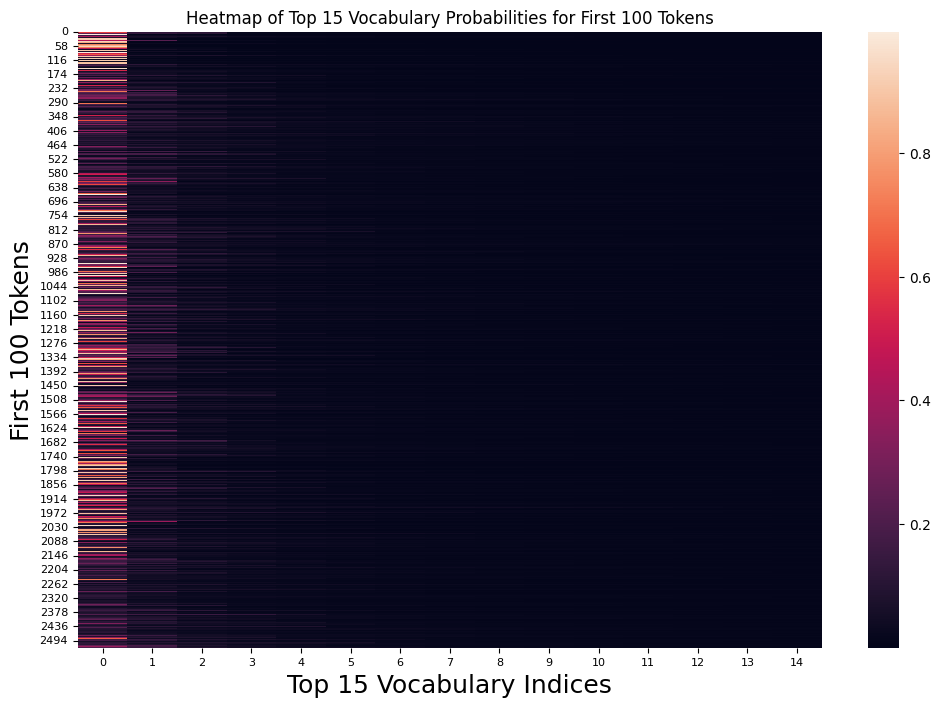

<Figure size 640x480 with 0 Axes>

In [6]:
RUN_DIR = '/localdisk/ssrivas9/prismatic-vlms/runs/reproduction-align-pythia+2p8b'
new_input_text = "A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: Is this person alone? Answer the question using a single word or phrase. ASSISTANT:"

inference_and_plot(RUN_DIR, new_input_text)